<a href="https://colab.research.google.com/github/sandrarairan/Modelo-Vision-florence/blob/main/Modelo_Vision_florence_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q transformers accelerate timm flash_attn einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 67.2 MB/s eta 0:00:00


In [3]:
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
# Cargar el modelo y el procesador
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
ave = Image.open('/content/pirangarubra.jpg')
imagen = Image.open('/content/srycereza.jpg')

## CAPTION

In [8]:
task = '<CAPTION>'
inputs = processor(text=task, images=ave, return_tensors="pt").to(device)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=task, image_size=(ave.width, ave.height))

print(parsed_answer)

{'<CAPTION>': '\na red bird sitting on top of a tree branch\n'}


## DETAILED_CAPTION

In [9]:
task = '<DETAILED_CAPTION>'
inputs = processor(text=task, images=ave, return_tensors="pt").to(device)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=task, image_size=(ave.width, ave.height))

print(parsed_answer)

{'<DETAILED_CAPTION>': '\nThe image shows a summer tanager perched atop a tree branch, its vibrant red feathers standing out against the lush green leaves in the background.\n'}


## Creemos una funcion

In [10]:
def run_example(task_prompt, text_input=None, image=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## MORE_DETAILED_CAPTION

In [11]:
run_example(task_prompt='<MORE_DETAILED_CAPTION>',image=ave)

{'<MORE_DETAILED_CAPTION>': '\nThe image shows a small red bird perched on a thin branch of a tree. The bird is facing towards the right side of the image and appears to be looking towards the left side. It has a bright red body with a black head and wings, and a long, pointed beak. The branch is covered in green leaves, and the background is blurred, suggesting that the bird is in a natural environment with other trees and foliage.\n'}

## OD - Object detection

In [12]:
task_prompt = '<OD>'
results = run_example(task_prompt,image=ave)
print(results)

{'<OD>': {'bboxes': [[254.52000427246094, 42.727500915527344, 421.5600280761719, 373.2074890136719]], 'labels': ['bird']}}


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

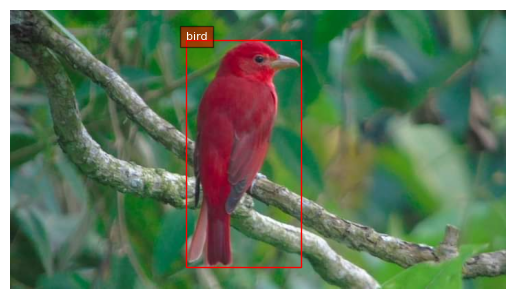

In [15]:
plot_bbox(ave, results['<OD>'])

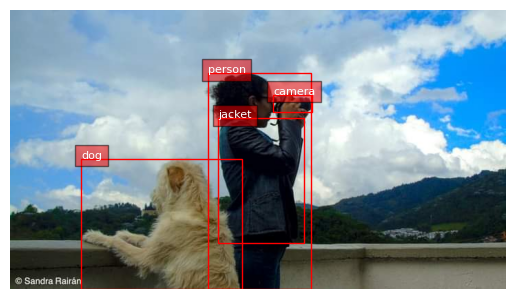

In [16]:
task_prompt = '<OD>'
results = run_example(task_prompt,image=imagen)
plot_bbox(imagen, results['<OD>'])

## DENSE_REGION_CAPTION

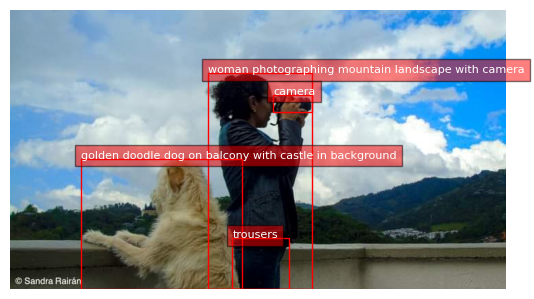

In [17]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt,image=imagen)
plot_bbox(imagen, results['<DENSE_REGION_CAPTION>'])

## CAPTION_TO_PHRASE_GROUNDING

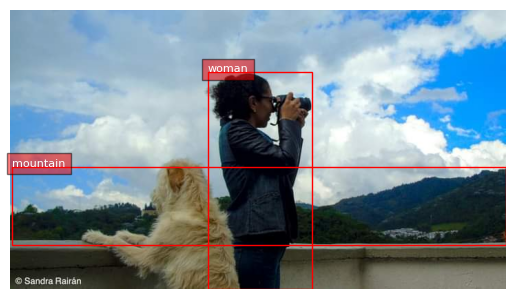

In [18]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="woman photographing mountain",image=imagen)
plot_bbox(imagen, results['<CAPTION_TO_PHRASE_GROUNDING>'])

## Segmentation

In [23]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="woman photographing",image=imagen)
results['<REFERRING_EXPRESSION_SEGMENTATION>']

{'polygons': [[[291.2400207519531,
    112.7925033569336,
    294.1200256347656,
    110.76750183105469,
    296.2799987792969,
    109.9574966430664,
    298.44000244140625,
    109.9574966430664,
    300.6000061035156,
    108.74250030517578,
    306.3600158691406,
    102.6675033569336,
    308.52001953125,
    101.85749816894531,
    309.96002197265625,
    101.85749816894531,
    314.2799987792969,
    97.80750274658203,
    316.44000244140625,
    96.59249877929688,
    319.32000732421875,
    95.78250122070312,
    326.52001953125,
    96.59249877929688,
    330.1200256347656,
    96.59249877929688,
    333.0,
    95.78250122070312,
    334.44000244140625,
    94.56749725341797,
    337.32000732421875,
    93.75749969482422,
    342.3600158691406,
    92.5425033569336,
    350.2799987792969,
    92.5425033569336,
    354.6000061035156,
    93.75749969482422,
    357.4800109863281,
    94.56749725341797,
    360.3600158691406,
    95.78250122070312,
    363.2400207519531,
    96.

In [24]:
results

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[291.2400207519531,
     112.7925033569336,
     294.1200256347656,
     110.76750183105469,
     296.2799987792969,
     109.9574966430664,
     298.44000244140625,
     109.9574966430664,
     300.6000061035156,
     108.74250030517578,
     306.3600158691406,
     102.6675033569336,
     308.52001953125,
     101.85749816894531,
     309.96002197265625,
     101.85749816894531,
     314.2799987792969,
     97.80750274658203,
     316.44000244140625,
     96.59249877929688,
     319.32000732421875,
     95.78250122070312,
     326.52001953125,
     96.59249877929688,
     330.1200256347656,
     96.59249877929688,
     333.0,
     95.78250122070312,
     334.44000244140625,
     94.56749725341797,
     337.32000732421875,
     93.75749969482422,
     342.3600158691406,
     92.5425033569336,
     350.2799987792969,
     92.5425033569336,
     354.6000061035156,
     93.75749969482422,
     357.4800109863281,
     94.5674972534179

In [25]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

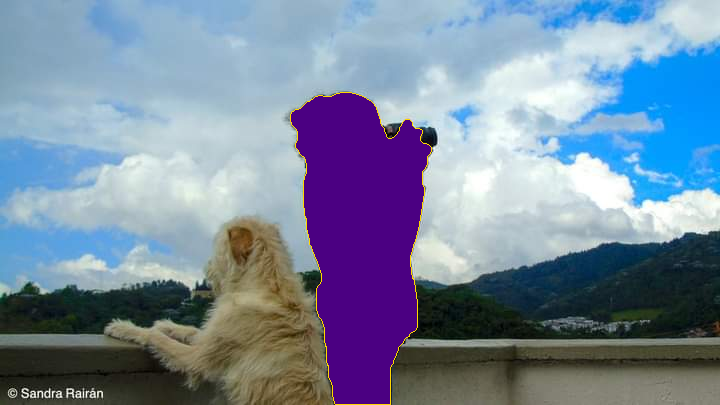

In [26]:
import copy
output_image = copy.deepcopy(imagen)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

## Text detection

In [27]:
flayer = Image.open('/content/gyrola_ia.001.jpeg')

In [28]:
task_prompt = '<OCR>'
run_example(task_prompt,image=flayer)

{'<OCR>': '\nLa fotografía de Tangara Gyrola con inteligencia artificial utilizandoStable Diffusion jugando con el estilo de fotorealista.Esta ave es conocida como Tangara cabeciroja (Tangara gyrola) es unaespecié de ave paseriforme de la familia Thraupidae.\n'}

In [29]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt,image=flayer)
print(results)

{'<OCR_WITH_REGION>': {'quad_boxes': [[340.79998779296875, 804.06005859375, 1586.8800048828125, 804.06005859375, 1586.8800048828125, 846.1800537109375, 340.79998779296875, 846.1800537109375], [459.8399963378906, 851.5800170898438, 1465.919921875, 851.5800170898438, 1465.919921875, 892.6200561523438, 459.8399963378906, 892.6200561523438], [292.79998779296875, 945.5400390625, 1634.8800048828125, 945.5400390625, 1634.8800048828125, 989.820068359375, 292.79998779296875, 987.6600341796875], [471.3599853515625, 993.06005859375, 1454.4000244140625, 993.06005859375, 1454.4000244140625, 1035.1800537109375, 471.3599853515625, 1035.1800537109375]], 'labels': ['</s>La fotografía de Tangara Gyrola con inteligencia artificial utilizando', 'Stable Diffusion jugando con el estilo de fotorealista.', 'Esta ave es conocida como Tangara cabecciroja (Tangara gyrola) es una', 'especié de ave paseriforne de la familia Thraupidae.']}}


In [30]:
def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    display(image)

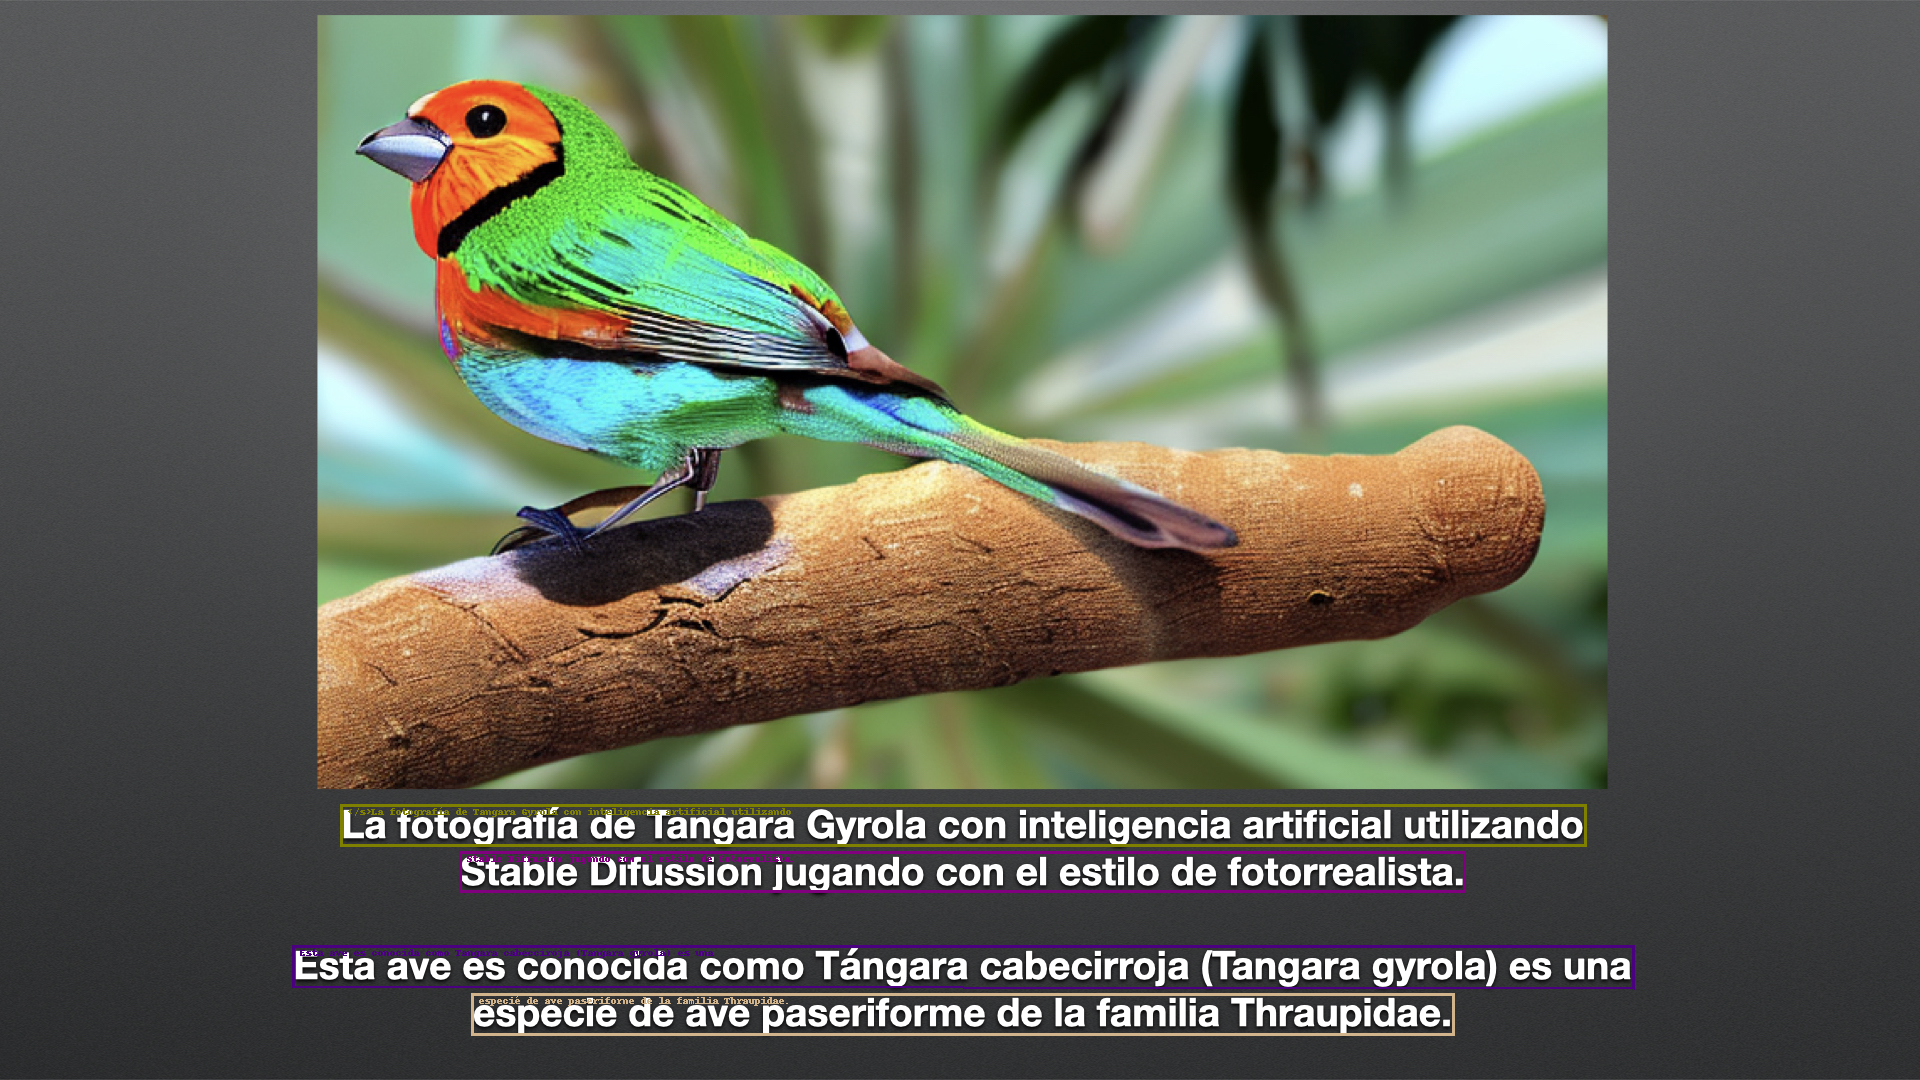

In [31]:
output_image = copy.deepcopy(flayer)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])

## Funciona con un video

In [32]:
# Configurar el video
video_path = '/content/video.mp4'
output_path = '/content/output.mp4'
cap = cv2.VideoCapture(video_path)

# Obtener propiedades del video
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec para el archivo de salida
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

prompt = "<OD>"
frame_count = 0

# Variables para almacenar las detecciones del último fotograma procesado
last_bboxes = []
last_labels = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Procesar solo cada 10 fotogramas
    if frame_count % 10 == 0:
        # Convertir el fotograma a una imagen PIL
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Procesar la imagen con Florence-2
        inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3,
            do_sample=False
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

        # Actualizar las detecciones del último fotograma procesado
        last_bboxes = parsed_answer['<OD>']['bboxes']
        last_labels = parsed_answer['<OD>']['labels']

    # Dibujar las cajas de detección y etiquetas en el fotograma utilizando las últimas detecciones procesadas
    for bbox, label in zip(last_bboxes, last_labels):
        x1, y1, x2, y2 = [int(coord) for coord in bbox]
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Escribir el fotograma procesado en el archivo de salida
    out.write(frame)
    frame_count += 1

cap.release()
out.release()
print(f"Processed {frame_count // 10} frames and saved to {output_path}")

Processed 40 frames and saved to /content/output.mp4
